<a href="https://colab.research.google.com/github/guscldns/TestProject/blob/main/0618/0615_03_Seq2Seq_%EA%B8%B0%EA%B3%84%EB%B2%88%EC%97%AD_%ED%95%9C%EC%98%81(%EC%8B%A4%EC%8A%B5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 그래프

In [ ]:
# 그래프에서 한글표현을 위해 폰트를 설치합니다.
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [ ]:
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

NanumGothic Eco


In [ ]:
plt.plot([1,2])
plt.title("한글 제목")

### 여기서 부터 시작

In [ ]:
# sys
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import time

import numpy as np
import pandas as pd

# visualize
import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm  # 폰트
# from matplotlib import rc # 폰트
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# tensorflow
import tensorflow as tf
## keras
from tensorflow.keras import layers, models, metrics, callbacks
## for modeling
from tensorflow.keras.layers import Input, Embedding, Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
## preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
## saving
from tensorflow.keras.saving import load_model
## utils
from tensorflow.keras.utils import plot_model

# from knockknock import desktop_sender
from tqdm import tqdm
tqdm.pandas()

## Download the data


In [ ]:
!gdown --id 1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1V6HsBoEczDoo4NDZ1I5iXSfRxFxCatis
To: /content/1_구어체(1).xlsx
100% 15.8M/15.8M [00:00<00:00, 26.9MB/s]


In [ ]:
import pandas as pd

df = pd.read_excel('/content/1_구어체(1).xlsx')
df

,SID,원문,번역문
0,1,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2,씨티은행에서 일하세요?,Do you work at a City bank?
2,3,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
199995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
199996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
199997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
199998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


In [ ]:
import pickle

with open('df.pickle', 'wb') as f:
    pickle.dump(df, f)
    f.close()

## Modeling


In [ ]:
HIDDEN_DIM = 512
EMBEDDING_DIM = 512
NUM_SAMPLES = 200000
BATCH_SIZE = 128
EPOCHS = 10

### 데이터 전처리

### 데이터 set

In [ ]:
ko_corpus = df['원문'] # source
en_corpus = df['번역문'] # target

In [ ]:
# 원문에서도 영어가 껴있고, 어차피 조사만 따로 버릴 것도 아니기에 한국어, 영어 동일하게 전처리 하겠습니다.
def preprocess_sentence(sent):
    sent = re.sub(r"([?.!,¿])", r" \1", sent) # 구두점 앞 공백 추가
    sent = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣!.?]+", r" ", sent)
    sent = re.sub(r"\s+", " ", sent) # 다수의 공백을 하나의 공백으로 치환

    return sent


# 학습 데이터, 타겟 데이터 생성 함수
def load_preprocessed_data(ko_corpus, en_corpus, debug=False):
    encoder_input, decoder_input, decoder_target = [], [], []
    # encoder_input: encoder layer에 들어갈 학습 데이터
    # decoder_input: decoder layer에 들어갈 학습 데이터(teacher forcing용)
    # decoder_target: decoder layer에서 나온 결과랑 비교할 타겟 데이터

    for i, (src_line, tar_line) in enumerate(zip(ko_corpus, en_corpus)):

        # source 데이터 (scr_lin) 전처리
        src_line = [w for w in preprocess_sentence(src_line).split()]

        # target 데이터 (tar_line) 전처리
        tar_line = preprocess_sentence(tar_line)
        tar_line_in = [w for w in ("<sos> " + tar_line).split()] # target for teacher forcing
        tar_line_out = [w for w in (tar_line + " <eos>").split()] # final target

        # reverse
        # src_line.reverse()

        # append
        encoder_input.append(src_line) # 클리닝
        decoder_input.append(tar_line_in) # sos + 클리닝
        decoder_target.append(tar_line_out) # 클리닝 + eos

        if i == NUM_SAMPLES - 1:
            break


        # debugging section
        if debug:
            print(f'(debug) 첫 번째 문장 작업 결과')
            print(f'src_line: \n{src_line}\n')
            print(f'tar_line_in: \n{tar_line_in}\n')
            print(f'tar_line_out: \n{tar_line_out}\n')
            break

    return encoder_input, decoder_input, decoder_target

In [ ]:
sents_ko_in, sents_en_in, sents_en_out  = load_preprocessed_data(ko_corpus, en_corpus, debug=False)

In [ ]:
import pickle

with open('sents_ko_in.pickle', 'wb') as f:
    pickle.dump(sents_ko_in, f)
    f.close()

with open('sents_en_in.pickle', 'wb') as f:
    pickle.dump(sents_en_in, f)
    f.close()

with open('sents_en_out.pickle', 'wb') as f:
    pickle.dump(sents_en_out, f)
    f.close()

In [ ]:
print('인코더의 입력 :',sents_ko_in[-5:])
print('디코더의 입력 :',sents_en_in[-5:])
print('디코더의 레이블 :',sents_en_out[-5:])

인코더의 입력 : [['나는', '먼저', '청소기로', '바닥을', '밀었어요', '.'], ['나는', '먼저', '팀', '과제를', '하고', '놀러', '갔어요', '.'], ['나는', '비', '같은', '멋진', '연예인을', '좋아해요', '.'], ['나는', '멋진', '자연', '경치를', '보고', '눈물을', '흘렸어', '.'], ['나는', '멋진', '중학교', '생활을', '기대합니다', '.']]
디코더의 입력 : [['<sos>', 'First', 'of', 'all', 'I', 'vacuumed', 'the', 'floor', '.'], ['<sos>', 'I', 'did', 'the', 'team', 'assignment', 'first', 'and', 'went', 'out', 'to', 'play', '.'], ['<sos>', 'I', 'like', 'cool', 'entertainer', 'like', 'Rain', '.'], ['<sos>', 'I', 'cried', 'seeing', 'the', 'amazing', 'scenery', '.'], ['<sos>', 'I', 'look', 'forward', 'to', 'a', 'great', 'middle', 'school', 'experience', '.']]
디코더의 레이블 : [['First', 'of', 'all', 'I', 'vacuumed', 'the', 'floor', '.', '<eos>'], ['I', 'did', 'the', 'team', 'assignment', 'first', 'and', 'went', 'out', 'to', 'play', '.', '<eos>'], ['I', 'like', 'cool', 'entertainer', 'like', 'Rain', '.', '<eos>'], ['I', 'cried', 'seeing', 'the', 'amazing', 'scenery', '.', '<eos>'], ['I', 'look', 'forwa

### 에러 시 여기서 부터

In [ ]:
import pickle

with open(r'df.pickle', 'rb') as file:
    df = pickle.load(file)
df

,SID,원문,번역문
0,1,'Bible Coloring'은 성경의 아름다운 이야기를 체험 할 수 있는 컬러링 ...,Bible Coloring' is a coloring application that...
1,2,씨티은행에서 일하세요?,Do you work at a City bank?
2,3,푸리토의 베스트셀러는 해외에서 입소문만으로 4차 완판을 기록하였다.,"PURITO's bestseller, which recorded 4th rough ..."
3,4,11장에서는 예수님이 이번엔 나사로를 무덤에서 불러내어 죽은 자 가운데서 살리셨습니다.,In Chapter 11 Jesus called Lazarus from the to...
4,5,"6.5, 7, 8 사이즈가 몇 개나 더 재입고 될지 제게 알려주시면 감사하겠습니다.",I would feel grateful to know how many stocks ...
...,...,...,...
199995,199996,나는 먼저 청소기로 바닥을 밀었어요.,"First of all, I vacuumed the floor."
199996,199997,나는 먼저 팀 과제를 하고 놀러 갔어요.,I did the team assignment first and went out t...
199997,199998,나는 비 같은 멋진 연예인을 좋아해요.,I like cool entertainer like Rain.
199998,199999,나는 멋진 자연 경치를 보고 눈물을 흘렸어.,I cried seeing the amazing scenery.


In [ ]:
import pickle

with open('sents_ko_in.pickle', 'rb') as file:
    sents_ko_in = pickle.load(file)

with open('sents_en_in.pickle', 'rb') as file:
    sents_en_in = pickle.load(file)

with open('sents_en_out.pickle', 'rb') as file:
    sents_en_out = pickle.load(file)

print(len(sents_ko_in), len(sents_en_in), len(sents_en_out))

200000 200000 200000


단어집합을 생성하겠습니다.

In [ ]:
# 한국어 단어집합
tokenizer_enc = Tokenizer(filters='', lower=False, oov_token='<UNK>')
tokenizer_enc.fit_on_texts(sents_ko_in)

# 인코더 데이터
encoder_input = tokenizer_enc.texts_to_sequences(sents_ko_in)


# 영어 단어집합
tokenizer_dec = Tokenizer(filters='', lower=False, oov_token='<UNK>')
tokenizer_dec.fit_on_texts(sents_en_in)
tokenizer_dec.fit_on_texts(sents_en_out)

# 디코더 데이터
decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
decoder_target = tokenizer_dec.texts_to_sequences(sents_en_out)


# 결과 확인
print(f'encoder_input: \n{encoder_input[-3:]}\n')
print(f'decoder_input: \n{decoder_input[-3:]}\n')
print(f'decoder_target: \n{decoder_target[-3:]}\n')

encoder_input: 
[[4, 1929, 91, 459, 13056, 325, 2], [4, 459, 2629, 7403, 94, 7201, 60226, 2], [4, 459, 2027, 1037, 2053, 2]]

decoder_input: 
[[3, 6, 39, 1013, 9159, 39, 7559, 2], [3, 6, 2840, 961, 5, 1571, 1964, 2], [3, 6, 219, 641, 7, 8, 230, 720, 121, 332, 2]]

decoder_target: 
[[6, 39, 1013, 9159, 39, 7559, 2, 4], [6, 2840, 961, 5, 1571, 1964, 2, 4], [6, 219, 641, 7, 8, 230, 720, 121, 332, 2, 4]]



In [ ]:
# # 한국어 (encoder)
# tokenizer_enc = Tokenizer(filters="", lower=False)
# tokenizer_enc.fit_on_texts(sents_fra_in)

# # 인코더 데이터
# encoder_input = tokenizer_enc.texts_to_sequences(sents_fra_in)

In [ ]:
# # 영어 (decoder)
# tokenizer_dec = Tokenizer(filters="", lower=False)
# tokenizer_dec.fit_on_texts(sents_en_in)
# tokenizer_dec.fit_on_texts(sents_en_out)

# # 디코더 데이터
# decoder_input = tokenizer_dec.texts_to_sequences(sents_en_in)
# decoder_target = tokenizer_dec.texts_to_sequences(sents_en_out)

In [ ]:
# print(encoder_input[-5:])
# print(decoder_input[-5:])
# print(decoder_target[-5:])

[[3, 143, 62221, 10321, 194646, 1], [3, 143, 1810, 2059, 47, 842, 527, 1], [3, 1928, 90, 458, 13055, 324, 1], [3, 458, 2628, 7402, 93, 7200, 60227, 1], [3, 458, 2026, 1036, 2052, 1]]
[[2, 443, 11, 67, 5, 42332, 4, 519, 1], [2, 5, 154, 4, 330, 2298, 111, 10, 156, 79, 6, 312, 1], [2, 5, 38, 1012, 9158, 38, 7558, 1], [2, 5, 2839, 960, 4, 1570, 1963, 1], [2, 5, 218, 640, 6, 7, 229, 719, 120, 331, 1]]
[[443, 11, 67, 5, 42332, 4, 519, 1, 3], [5, 154, 4, 330, 2298, 111, 10, 156, 79, 6, 312, 1, 3], [5, 38, 1012, 9158, 38, 7558, 1, 3], [5, 2839, 960, 4, 1570, 1963, 1, 3], [5, 218, 640, 6, 7, 229, 719, 120, 331, 1, 3]]


In [ ]:
SRC_VOCAB_SIZE = len(tokenizer_enc.word_index) + 1
TAR_VOCAB_SIZE = len(tokenizer_dec.word_index) + 1

print(f"한국어 단어 집합의 크기 : {SRC_VOCAB_SIZE}, 영어 단어 집합의 크기 : {TAR_VOCAB_SIZE}")

한국어 단어 집합의 크기 : 194653, 영어 단어 집합의 크기 : 42334


각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [ ]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [ ]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

# 변수 저장
MAX_ENC_LEN, MAX_DEC_LEN = encoder_input.shape[1], decoder_input.shape[1]

인코더의 입력의 크기(shape) : (200000, 31)
디코더의 입력의 크기(shape) : (200000, 52)
디코더의 레이블의 크기(shape) : (200000, 52)


단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용합니다.

In [ ]:
src2idx = tokenizer_enc.word_index  # word : idx
idx2src = tokenizer_enc.index_word  # idx : word
tar2idx = tokenizer_dec.word_index # word : idx
idx2tar = tokenizer_dec.index_word # idx : word

In [ ]:
print(src2idx)
print(idx2src)
print(tar2idx)
print(idx2tar)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



테스트 데이터를 분리하겠습니다. 인코더 input, 디코더 input, 디코더 output이 동일하게 분리되어야 하기 때문에 랜덤한 정수배열을 만들어 직접 나누겠습니다.

우선 랜덤하게 시퀀스를 섞습니다.

In [ ]:
# 랜덤 인덱스 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

# 랜덤하게 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

print()
print(decoder_input[indices[0]])
print(decoder_target[indices[0]])

랜덤 시퀀스 : [198442 164074   4683 ...  76020  65523  90707]

[   3   34   23 1610   17   35   18 4159    5 2619  654   13   27  485
    2    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
[  34   23 1610   17   35   18 4159    5 2619  654   13   27  485    2
    4    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]


`<sos>` `<eos>` 토큰을 제외한 다른 단어들은 동일한 인덱스를 갖고 있어야 합니다.

10%의 데이터를 test데이터로 분리하겠습니다.

In [ ]:
n_of_val = int(NUM_SAMPLES*0.15) # 900

# train data
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# test data
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (170000, 31)
훈련 target 데이터의 크기 : (170000, 52)
훈련 target 레이블의 크기 : (170000, 52)
테스트 source 데이터의 크기 : (30000, 31)
테스트 target 데이터의 크기 : (30000, 52)
테스트 target 레이블의 크기 : (30000, 52)


## 모델링 (학습)

#### 1. 인코더

인코더를 설계합니다.

LSTM 레이어를 사용하므로 context vector는 `hidden state`와 `cell state` 총 2가지 모두를 사용합니다.
- 이 두 가지 상태를 encoder_states로 묶어서 저장하겠습니다.

#### 2. 디코더

1. 디코더는 인코더의 마지막 은닉 상태로부터 초기 은닉 상태를 얻습니다.
    - initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다.

2. 디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다. (Teacher Forcing을 위해)

3. seq2seq의 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고있습니다.
    - 매 시점마다 프랑스어 단어 집합의 크기(tar_vocab_size)의 선택지에서 단어를 1개 선택하여 이를 이번 시점에서 예측한 단어로 택합니다.
    - 다중 클래스 분류 문제이므로 출력층으로 소프트맥스 함수와 손실 함수를 크로스 엔트로피 함수를 사용합니다.
        - categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다
        - 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다.
        - 원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 `categorical_crossentropy`가 아니라 `sparse_categorical_crossentropy`를 사용하면 됩니다.

In [ ]:
# from tensorflow.keras.layers import Embedding, GRU, Dense ,LSTM, Input
# # 인코더 (Train)

# ## 층
# enc_emb_layer = Embedding(SRC_VOCAB_SIZE, EMBEDDING_DIM)
# encoder_lstm = LSTM(HIDDEN_DIM, return_state = True) # 상태값 리턴을 위해 return_state는 True


# ## input -> output
# encoder_inputs = Input(shape=(None, ))
# enc_emb = enc_emb_layer(encoder_inputs)
# encoder_outputs, state_h, state_c =  encoder_lstm(enc_emb)

# encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 리스트로 저장

In [ ]:
# # 디코더 (Train)

# ## 층
# #상태값 리턴을 위해 lstm layer return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
# dec_emb_layer = Embedding(TAR_VOCAB_SIZE, HIDDEN_DIM)
# decoder_lstm = LSTM(HIDDEN_DIM, return_sequences=True, return_state = True)
# decoder_dense = Dense(TAR_VOCAB_SIZE, activation = 'softmax')


# ## input -> output
# # 인코더 RNN의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
# decoder_inputs = Input(shape=(None, ))
# dec_emb = dec_emb_layer(decoder_inputs)
# decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

# # 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
# decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, InputLayer, Dense, Embedding, Input, Attention, Flatten, GRU
from tensorflow.keras import Model

# enc
enc_emb_layer = Embedding(SRC_VOCAB_SIZE, EMBEDDING_DIM)
enc_gru = GRU(HIDDEN_DIM,return_sequences = True, return_state= True)


encoder_inputs = Input(shape=(None, ))
enc_emb = enc_emb_layer(encoder_inputs)
encoder_outputs, state_h =  enc_gru(enc_emb)

# hidden state 저장
encoder_states = [state_h]

# dec
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, HIDDEN_DIM)
decoder_gru = GRU(HIDDEN_DIM, return_sequences=True, return_state = True)
decoder_dense = Dense(TAR_VOCAB_SIZE, activation = 'softmax')


## input -> output
# 인코더 RNN의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_inputs = Input(shape=(None, ))
dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, _ = decoder_gru(dec_emb, initial_state = encoder_states)

att = Attention()([decoder_outputs, encoder_outputs]) # 앞이 쿼리, 뒤에가 value
# 어텐션은 인코더에 가중치를 곱하는 것, 디코더 정보는 추가해서 넣어줘야 함
# Concatenate에 어텐션, 디코더 정보 합쳐주는 작업 필요
concat = tf.keras.layers.Concatenate()([att, decoder_outputs])

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_outputs = decoder_dense(concat)

In [ ]:
# 모델의 입력과 출력을 정의.
model = Model(inputs = [encoder_inputs, decoder_inputs], outputs = decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 512)    99662336    ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 512)    21675008    ['input_4[0][0]']                
                                                                                            

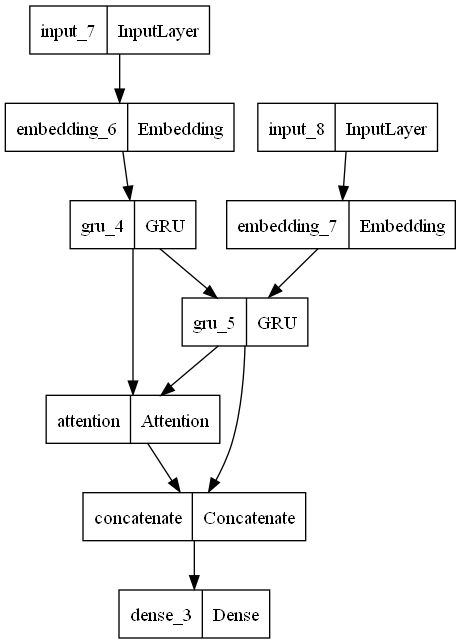

In [ ]:
tf.keras.utils.plot_model(model, to_file='model.png', )

In [ ]:
# 변수
HIDDEN_DIM = 512
EMBEDDING_DIM = 512
NUM_SAMPLES = 200000
BATCH_SIZE = 128
EPOCHS = 1

In [ ]:
model = load_model('/content/best_model_vs.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)
model_save = tf.keras.callbacks.ModelCheckpoint(filepath = 'best_model_.h5', verbose = 1, save_best_only = True)

history = model.fit(x = [encoder_input_train, decoder_input_train],
          y = decoder_target_train,

          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = BATCH_SIZE,
          callbacks = [earlystopping, model_save],
          epochs = EPOCHS)

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(12, 6))

  plt.subplot(1,2,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Loss')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['acc'],
           label='Train Acc')
  plt.plot(hist['epoch'], hist['val_acc'],
           label = 'Val Acc')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)

## Inference

- 학습된 모델을 바탕으로 번역기를 만들어봅시다. -> 즉 inference용 번역기

- *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.

    1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
    2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
    3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

### 모델 불러오기

In [ ]:
model.load_weights('/content/best_model_vs.h5')

OSError: ignored

In [ ]:
from keras.models import load_model
model = load_model('/content/best_model_vs.h5')

OSError: ignored

In [ ]:
# # 0. 사용할 패키지 불러오기
# from keras.utils import np_utils
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Activation
# import numpy as np
# from numpy import argmax

# # 1. 실무에 사용할 데이터 준비하기
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_test = x_test.reshape(10000, 784).astype('float32') / 255.0
# y_test = np_utils.to_categorical(y_test)
# xhat_idx = np.random.choice(x_test.shape[0], 5)
# xhat = x_test[xhat_idx]

# # 2. 모델 불러오기
# from keras.models import load_model
# model = load_model('mnist_mlp_model.h5')

# # 3. 모델 사용하기
# yhat = model.predict_classes(xhat)

# for i in range(5):
#     print('True : ' + str(argmax(y_test[xhat_idx[i]])) + ', Predict : ' + str(yhat[i]))

In [ ]:
# 인코더 - 훈련과 동일
encoder_model = Model(encoder_inputs, encoder_states)

In [ ]:
encoder_input_train[0:1]

array([[ 18,  23,   3,  22, 254,   1,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int32)

In [ ]:
# 인코더 모델 확인
ht, ct = encoder_model(encoder_input_train[0:1])
ht.shape, ct.shape

(TensorShape([1, 256]), TensorShape([1, 256]))

In [ ]:
# 디코더 (Predict)

# Input Tensors : 이전 시점의 상태를 보관할 텐서
decoder_input_h = Input(shape=(HIDDEN_DIM,))
decoder_input_c = Input(shape=(HIDDEN_DIM,))

decoder_states_inputs = [decoder_input_h, decoder_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
x = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h2, state_c2 = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측 (Fully Connected)
x = decoder_dense(x)

# 수정된 디코더
decoder_model = Model(
    inputs = [decoder_inputs] + decoder_states_inputs,
    outputs = [x] + decoder_states2)

In [ ]:
temp_h = np.random.rand(1, 256)
temp_c = np.random.rand(1, 256)

In [ ]:
x, h, c = decoder_model([decoder_input_train[0:1], temp_h, temp_c])

In [ ]:
x.shape

TensorShape([1, 8, 4518])

In [ ]:
h.shape

TensorShape([1, 256])

In [ ]:
c.shape

TensorShape([1, 256])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, InputLayer, Dense, Embedding, Input, Attention, Flatten, GRU
from tensorflow.keras import Model

# enc
encoder_model = Model(encoder_inputs, encoder_states)

# dec
dec_emb_layer = Embedding(TAR_VOCAB_SIZE, HIDDEN_DIM)
decoder_gru = GRU(HIDDEN_DIM, return_sequences=True, return_state = True)
decoder_dense = Dense(TAR_VOCAB_SIZE, activation = 'softmax')

## input -> output
# 인코더 RNN의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_inputs = Input(shape=(None, ))
dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, _ = decoder_gru(dec_emb, initial_state = encoder_states)

att = Attention()([decoder_outputs, encoder_outputs]) # 앞이 쿼리, 뒤에가 value
# 어텐션은 인코더에 가중치를 곱하는 것, 디코더 정보는 추가해서 넣어줘야 함
# Concatenate에 어텐션, 디코더 정보 합쳐주는 작업 필요
concat = tf.keras.layers.Concatenate()([att, decoder_outputs])

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_outputs = decoder_dense(concat)

# Input Tensors : 이전 시점의 상태를 보관할 텐서
decoder_input_h = Input(shape=(HIDDEN_DIM,))

decoder_states_inputs = [decoder_input_h]

# 훈련 때 사용했던 임베딩 층을 재사용
x = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
x, state_h2,_ = decoder_lstm(x, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2]

# 모든 시점에 대해서 단어 예측 (Fully Connected)
x = decoder_dense(x)

# 수정된 디코더
decoder_model = Model(
    inputs = [decoder_inputs] + decoder_states_inputs,
    outputs = [x] + decoder_states2)

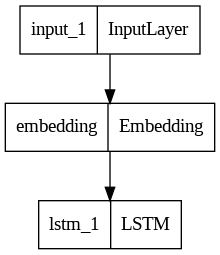

In [ ]:
# 인코더 모델 시각화
tf.keras.utils.plot_model(encoder_model)

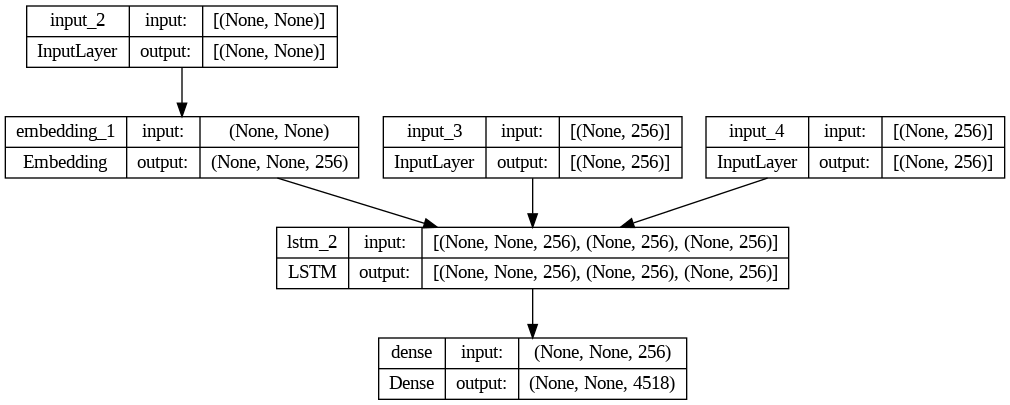

In [ ]:
# 디코더 모델 시각화
tf.keras.utils.plot_model(decoder_model, show_shapes = True)

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다.
1. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. -> `states_value`
2. 디코더의 초기 입력으로 <SOS>를 준비합니다. -> `target_seq`
3. 이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다.
4. 이제 디코더는 현재 시점에 대해서 예측합니다.
    - 예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다.
    - while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다.
    - 이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다.
5. 각 시점마다 번역된 단어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.

In [ ]:
sentence = 'Je lui ai prêté un CD.'

sentence = preprocess_sentence(sentence)
tokens = sentence.split(" ")
print('token :', tokens)

token : ['je', 'lui', 'ai', 'prete', 'un', 'cd', '.']


In [ ]:
# 입력 문장 토큰 -> 라벨링
enc_input = tokenizer_enc.texts_to_sequences([tokens])
print('enc_input: ', enc_input)
# 입력 문장 라벨링 -> 패딩
enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
print('enc_input: ', enc_input)

enc_input:  [[2, 97, 12, 327, 22, 2132, 1]]
enc_input:  [[   2   97   12  327   22 2132    1    0    0    0    0    0    0    0
     0]]


In [ ]:
states_value = encoder_model.predict(enc_input)

1/1 [==============================] - 1s 540ms/step


In [ ]:
states_value[0].shape, states_value[1].shape

((1, 256), (1, 256))

In [ ]:
# Decoder input인 <SOS>에 해당하는 정수 생성
target_seq = np.zeros((1,1))
target_seq[0, 0] = tar2idx['<sos>']


# prediction 시작
    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
stop_condition = False
decoded_sentence = ''

for t in range(MAX_DEC_LEN):

    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)

    # 예측 결과를 단어로 변환
    result_token_index = np.argmax(output_tokens[0, -1, :])
    result_word = idx2tar[result_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+result_word

    # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = result_token_index

    # 현재 시점의 상태 ->  다음 시점의 상태로 업데이트
    states_value = [h, c]

    #  Stop condition <eos>에 도달하면 중단.
    if result_word == '<eos>':
        break


print(decoded_sentence.strip(' <eos>'))

i made a deal .


In [ ]:
def translate(sentence):
    sentence = preprocess_sentence(sentence)
    tokens = sentence.split(" ")

    # 입력 문장 토큰 -> 라벨링
    enc_input = tokenizer_enc.texts_to_sequences([tokens])

    # 입력 문장 라벨링 -> 패딩
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, maxlen=MAX_ENC_LEN, padding='post')
    states_value = encoder_model.predict(enc_input)

    # Decoder input인 <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar2idx['<sos>']


    # prediction 시작
        # stop_condition이 True가 될 때까지 루프 반복
        # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    stop_condition = False
    decoded_sentence = ''

    for t in range(MAX_DEC_LEN):

        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose = 0)

        # 예측 결과를 단어로 변환
        result_token_index = np.argmax(output_tokens[0, -1, :])
        result_word = idx2tar[result_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+result_word

        # 현재 시점의 예측 결과 -> 다음 시점의 입력으로 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = result_token_index

        # 현재 시점의 상태 ->  다음 시점의 상태로 업데이트
        states_value = [h, c]

        #  Stop condition <eos>에 도달하면 중단.
        if result_word == '<eos>':
            break

    return decoded_sentence.strip(' <eos>')

## 결과 확인

결과 확인을 위한 함수를 만듭니다.

In [ ]:
train_idx = indices[:-n_of_val]
test_idx = indices[-n_of_val:]

In [ ]:
n_samples = 5
np.random.choice(train_idx, n_samples)

array([ 3222, 22791,  4579, 26772, 11082])

In [ ]:
# train data - translate
n_samples = 5
for idx in np.random.choice(train_idx, n_samples):
    test_sentence = fra_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 21ms/step
입력문장 : Pouvez-vous aider ?
정답문장 : Can you help?
번역문장 : can you help ?
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : Je n'avais aucune idée.
정답문장 : I had no clue.
번역문장 : i had no idea .
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : C'est vous la maîtresse.
정답문장 : You're the master.
번역문장 : you re the master .
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
입력문장 : Je ne suis pas en train de mourir.
정답문장 : I'm not dying.
번역문장 : i m not married .
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : Avez-vous tué Tom ?
정답문장 : Did you kill Tom?
번역문장 : did you murder tom ?
--------------------------------------------------


In [ ]:
# test data - translate
n_samples = 5
for idx in np.random.choice(test_idx, n_samples):
    test_sentence = fra_corpus[idx]
    answer_sentence = eng_corpus[idx]
    decoded_sentence = translate(test_sentence)

    print("입력문장 :", test_sentence)
    print("정답문장 :", answer_sentence)
    print("번역문장 :", decoded_sentence)
    print("-"*50)

1/1 [==============================] - 0s 20ms/step
입력문장 : Je dis que je l'aimais.
정답문장 : I said I liked it.
번역문장 : i said i liked it .
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
입력문장 : Je ne m'y suis jamais fait prendre.
정답문장 : I never got caught.
번역문장 : i never went back .
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : Nous l'avons vue.
정답문장 : We've seen her.
번역문장 : we ve seen it .
--------------------------------------------------
1/1 [==============================] - 0s 17ms/step
입력문장 : C'est ta moitié.
정답문장 : That's your half.
번역문장 : this is your fate .
--------------------------------------------------
1/1 [==============================] - 0s 18ms/step
입력문장 : Demande à n'importe qui !
정답문장 : Ask anybody.
번역문장 : ask anybody .
--------------------------------------------------


## BLEU Score (Bilingual Evaluation Understudy Score)
기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법 중 하나인 BLEU(Bilingual Evaluation Understudy)를 측정해봅시다.
- 논문 : BLEU: a Method for Automatic Evaluation of Machine Translation
- BLEU 점수는 기계 번역된 텍스트와 고품질 참조 번역 세트의 유사성을 측정하는 0과 1 사이의 숫자입니다.
    - 값이 0이면 기계 번역된 출력이 참조 번역과 겹치는 부분이 없는 것을 의미하고(저품질)
    - 1이면 참조 번역과 완벽하게 겹치는 것을 의미합니다(고품질)

- BLEU 설명
    - https://jrc-park.tistory.com/273
    - https://wikidocs.net/31695
    - https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu

BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법입니다.

In [ ]:
!pip install evaluate

In [ ]:
bleu = evaluate.load("bleu")
bleu

In [ ]:
bleu

In [ ]:
import evaluate
predictions = ["hello there general kenobi", "foo bar foobar"]
references = [
    ["hello there general kenobi", "hello there !"],
    ["foo bar foobar"]
 ]

bleu = evaluate.load("bleu")

results = bleu.compute(predictions=predictions, references=references)

print(results)

{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.1666666666666667, 'translation_length': 7, 'reference_length': 6}


In [ ]:
results

{'bleu': 1.0,
 'precisions': [1.0, 1.0, 1.0, 1.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1666666666666667,
 'translation_length': 7,
 'reference_length': 6}

In [ ]:
from tqdm.notebook import tqdm

n_samples = 10
ref_train, pred_train = [], []
for idx in tqdm(np.random.choice(test_idx, n_samples)):
    ref_train.append(eng_corpus[idx])
    pred_train.append(translate(fra_corpus[idx]))


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


In [ ]:
print(ref_train)
print(pred_train)

['I recovered.', "I know you're busy.", 'I like history.', 'Give me your keys.', 'I just got engaged.', 'Did Tom find it?', 'Forget it!', 'Put it over there.', "You're fortunate.", 'Tom came forward.']
['i m feeling low .', 'i know you re busy .', 'i like this model .', 'give me your knife .', 'i just remembered .', 'is tom working ?', 'let it go .', 'put it on the way .', 'you re stubborn .', 'tom became quiet .']


In [ ]:
bleu.compute(predictions=pred_train, references=ref_train)

{'bleu': 0.0,
 'precisions': [0.3617021276595745, 0.05405405405405406, 0.0, 0.0],
 'brevity_penalty': 1.0,
 'length_ratio': 1.119047619047619,
 'translation_length': 47,
 'reference_length': 42}

### Reference

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://wikidocs.net/86900